In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial
import glob, os

def load_data(data_dir="data", pattern="pv*.csv"):
    """Load CSV files, concatenate, and return DataFrame indexed by Zoom."""
    data_files = glob.glob(os.path.join(data_dir, pattern))
    df_from_each_file = (pd.read_csv(f) for f in data_files)
    df = pd.concat(df_from_each_file, ignore_index=True).set_index('Zoom')
    return df

def _xy_from_df(df, col):
    x = df.index.values.astype(float)
    y = df[col].values.astype(float)
    m = ~np.isnan(y)
    return x[m], y[m]

def fit_poly_positive(df, col, deg, domain=None):
    """
    Fit a polynomial to log(y + eps) to ensure yhat >= 0.
    Returns (poly_g, eval_fn) where eval_fn(x) gives positive predictions.
    """
    x, y = _xy_from_df(df, col)

    # choose eps proportional to scale so zeros are handled but not distorted
    eps = 1e-6 * max(1.0, np.nanmax(y))
    y_safe = np.maximum(0.0, y) + eps

    if domain is None:
        domain = [float(np.min(x)), float(np.max(x))]

    g = Polynomial.fit(x, np.log(y_safe), deg, domain=domain)

    # positive by construction; add small clip-to-range safety
    y_min, y_max = float(np.nanmin(y)), float(np.nanmax(y))

    def eval_pos(xq):
        yq = np.exp(g(xq)) - eps
        # numerical guard: clip to observed data range
        return np.clip(yq, 0.0, max(y_max, 0.0) * 1.2)

    return g, eval_pos


In [2]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.termination import get_termination

class JointLUTOptimizationProblem(ElementwiseProblem):
    """
    Optimize a LUT shared for both Close and Far:
    - decision vars: [deg_close, deg_far, inner zoom points...]
    - first 2 variables are polynomial degrees
    - remaining are inner zoom points (excluding min/max)
    """
    def __init__(self, df, lut_length, deg_min=2, deg_max=8,
                 monotonic_penalty=False, mono_lambda=1e-3):
        self.df = df
        self.lut_length = lut_length
        self.deg_min = deg_min
        self.deg_max = deg_max

        self.zoom_min = int(np.floor(df.index.min()))
        self.zoom_max = int(np.ceil(df.index.max()))
        self.domain = [float(self.zoom_min), float(self.zoom_max)]

        self.monotonic_penalty = monotonic_penalty
        self.mono_lambda = mono_lambda

        n_var = 2 + (lut_length - 2)  # deg_close, deg_far + inner zoom points
        xl = np.array([deg_min, deg_min] + [self.zoom_min]*(lut_length-2), dtype=float)
        xu = np.array([deg_max, deg_max] + [self.zoom_max]*(lut_length-2), dtype=float)
        super().__init__(n_var=n_var, n_obj=1, xl=xl, xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        # parse decision vector
        deg_close = int(np.rint(x[0]))
        deg_far   = int(np.rint(x[1]))
        # inner zooms as sorted unique integers
        inner_zooms = np.sort(np.unique(np.rint(x[2:]).astype(int)))

        # must have exactly lut_length-2 unique integers
        if inner_zooms.size != (self.lut_length - 2):
            out["F"] = 1e9
            return

        # build full zoom grid (include endpoints)
        zoom_points = np.concatenate(([self.zoom_min], inner_zooms, [self.zoom_max]))

        # Fit positive polynomials
        try:
            g_close, f_close = fit_poly_positive(self.df, "Close", deg_close, domain=self.domain)
            g_far,   f_far   = fit_poly_positive(self.df, "Far", deg_far, domain=self.domain)
        except Exception:
            out["F"] = 1e9
            return

        # Build integer LUTs
        close_vals = np.rint(f_close(zoom_points)).astype(int)
        far_vals   = np.rint(f_far(zoom_points)).astype(int)

        # Compute residuals
        def compute_resid(col, vals):
            pred = np.interp(self.df.index, zoom_points, vals)
            y_all = self.df[col].values
            with np.errstate(divide='ignore', invalid='ignore'):
                resid = 100.0*(y_all - pred)/y_all
            resid = resid[np.isfinite(resid)]
            return resid

        resid_close = compute_resid("Close", close_vals)
        resid_far   = compute_resid("Far", far_vals)

        mae_close = np.mean(np.abs(resid_close)) if resid_close.size else 1e9
        mae_far   = np.mean(np.abs(resid_far))   if resid_far.size else 1e9

        # objective: robust blend of MAE and 95th percentile
        mae_far = np.mean(np.abs(resid_far)) if resid_far.size else 1e9
        p95_far = np.percentile(np.abs(resid_far), 95) if resid_far.size else 1e9
        obj_far = 0.7 * mae_far + 0.3 * p95_far
        mae_close = np.mean(np.abs(resid_close)) if resid_close.size else 1e9
        p95_close = np.percentile(np.abs(resid_close), 95) if resid_close.size else 1e9
        obj_close = 0.7 * mae_close + 0.3 * p95_close
        obj = 0.5*(obj_far + obj_close)

        # small regularization on polynomial to avoid runaway degrees
        obj += 1e-4*(deg_close + deg_far)

        # optional monotonicity penalty
        if self.monotonic_penalty:
            for vals in [close_vals, far_vals]:
                diffs = np.diff(vals.astype(float))
                neg = diffs[diffs < 0]
                if neg.size:
                    obj += self.mono_lambda * np.sum(np.abs(neg))

        out["F"] = float(obj)



def optimize_joint_lut(df, lut_length, deg_min=2, deg_max=10,
                       pop_size=120, n_gen=200,
                       monotonic_penalty=True, mono_lambda=1e-3):
    problem = JointLUTOptimizationProblem(df, lut_length,
                                          deg_min, deg_max,
                                          monotonic_penalty, mono_lambda)
    
    algo = GA(pop_size=pop_size, eliminate_duplicates=True)
    termination = get_termination("n_gen", n_gen)

    res = minimize(problem, algo, termination, verbose=False)
    best = np.array(res.X).reshape(-1)  # flatten to 1D
    deg_close = int(np.rint(best[0]))
    deg_far   = int(np.rint(best[1]))
    inner_zooms = np.sort(np.rint(best[2:]).astype(int))
    zoom_points = np.concatenate(([problem.zoom_min], inner_zooms, [problem.zoom_max]))

    # LUTs
    _, f_close = fit_poly_positive(df, "Close", deg_close, domain=problem.domain)
    _, f_far   = fit_poly_positive(df, "Far", deg_far, domain=problem.domain)
    lut_close = pd.DataFrame({"Zoom": zoom_points, "Fit": np.rint(f_close(zoom_points)).astype(int)})
    lut_far   = pd.DataFrame({"Zoom": zoom_points, "Fit": np.rint(f_far(zoom_points)).astype(int)})

    # Residuals
    def compute_resid(col, vals):
        pred = np.interp(df.index, zoom_points, vals)
        y_all = df[col].values
        with np.errstate(divide='ignore', invalid='ignore'):
            resid = 100.0*(y_all - pred)/y_all
        resid = resid[np.isfinite(resid)]
        return resid

    resid_close = compute_resid("Close", lut_close["Fit"].values)
    resid_far   = compute_resid("Far", lut_far["Fit"].values)

    metrics = {
        "Close": {"mae_%": np.mean(np.abs(resid_close)), "max_%": np.max(np.abs(resid_close))},
        "Far":   {"mae_%": np.mean(np.abs(resid_far)),   "max_%": np.max(np.abs(resid_far))}
    }

    return {
        "deg_close": deg_close,
        "deg_far": deg_far,
        "zoom_points": zoom_points,
        "lut_close": lut_close,
        "lut_far": lut_far,
        "resid_close": resid_close,
        "resid_far": resid_far,
        "metrics": metrics
    }


def optimize_joint_lut_length(df, lut_min=3, lut_max=8,
                              deg_min=2, deg_max=8,
                              pop_size=100, n_gen=150,
                              monotonic_penalty=True, mono_lambda=1e-3):
    best_overall_score = np.inf
    best_lut_length = None
    best_joint_lut = None

    for lut_len in range(lut_min, lut_max + 1):
        print(f"Trying shared LUT length = {lut_len} ...")
        joint_lut = optimize_joint_lut(df, lut_len,
                                       deg_min=deg_min, deg_max=deg_max,
                                       pop_size=pop_size, n_gen=n_gen,
                                       monotonic_penalty=monotonic_penalty,
                                       mono_lambda=mono_lambda)
        
        # Combine MAE% for Close and Far
        mae_close = joint_lut["metrics"]["Close"]["mae_%"]
        mae_far   = joint_lut["metrics"]["Far"]["mae_%"]
        combined_mae = 0.5 * (mae_close + mae_far)

        # Penalize longer LUTs lightly
        penalized_score = combined_mae + 0.1 * lut_len
        print(f"  Combined MAE%={combined_mae:.3f}, Penalized Score={penalized_score:.3f}")

        if penalized_score < best_overall_score:
            best_overall_score = penalized_score
            best_lut_length = lut_len
            best_joint_lut = joint_lut

    print(f"\nBest shared LUT length = {best_lut_length}, Combined MAE% = {best_overall_score:.3f}")
    return {
        "lut_length": best_lut_length,
        **best_joint_lut
    }

def plot_lut_with_residuals(df, col, lut, residuals):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Left: data vs LUT
    axs[0].scatter(df.index, df[col], label=f"{col} data", alpha=0.6)
    axs[0].plot(lut['Zoom'], lut['Fit'], 'o-', color='r', label='Optimized LUT')
    axs[0].set_title(f"{col}: Data & Optimized LUT")
    axs[0].set_xlabel("Zoom")
    axs[0].set_ylabel("Focus")
    axs[0].legend()
    axs[0].grid(True)

    # Right: residuals (make sure same length)
    if len(residuals) != len(df.index):
        residuals = np.interp(df.index, lut['Zoom'], lut['Fit'])
        residuals = 100.0 * (df[col].values - residuals) / df[col].values

    axs[1].scatter(df.index, residuals, alpha=0.6)
    axs[1].axhline(0, color='k', linestyle='--')
    axs[1].set_title(f"{col}: LUT % Residuals")
    axs[1].set_xlabel("Zoom")
    axs[1].set_ylabel("% Residuals")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


Trying shared LUT length = 3 ...
  Combined MAE%=4.252, Penalized Score=4.552
Trying shared LUT length = 4 ...
  Combined MAE%=2.368, Penalized Score=2.768
Trying shared LUT length = 5 ...
  Combined MAE%=1.422, Penalized Score=1.922
Trying shared LUT length = 6 ...
  Combined MAE%=1.228, Penalized Score=1.828
Trying shared LUT length = 7 ...
  Combined MAE%=1.057, Penalized Score=1.757
Trying shared LUT length = 8 ...
  Combined MAE%=0.924, Penalized Score=1.724
Trying shared LUT length = 9 ...
  Combined MAE%=0.892, Penalized Score=1.792
Trying shared LUT length = 10 ...
  Combined MAE%=0.864, Penalized Score=1.864
Trying shared LUT length = 11 ...
  Combined MAE%=0.883, Penalized Score=1.983
Trying shared LUT length = 12 ...
  Combined MAE%=0.859, Penalized Score=2.059
Trying shared LUT length = 13 ...
  Combined MAE%=0.842, Penalized Score=2.142
Trying shared LUT length = 14 ...
  Combined MAE%=0.840, Penalized Score=2.240
Trying shared LUT length = 15 ...
  Combined MAE%=0.853, Pe

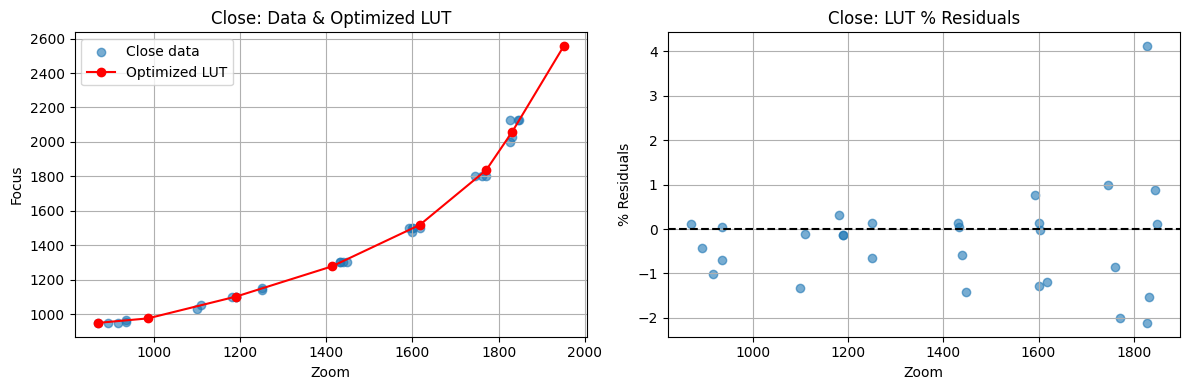

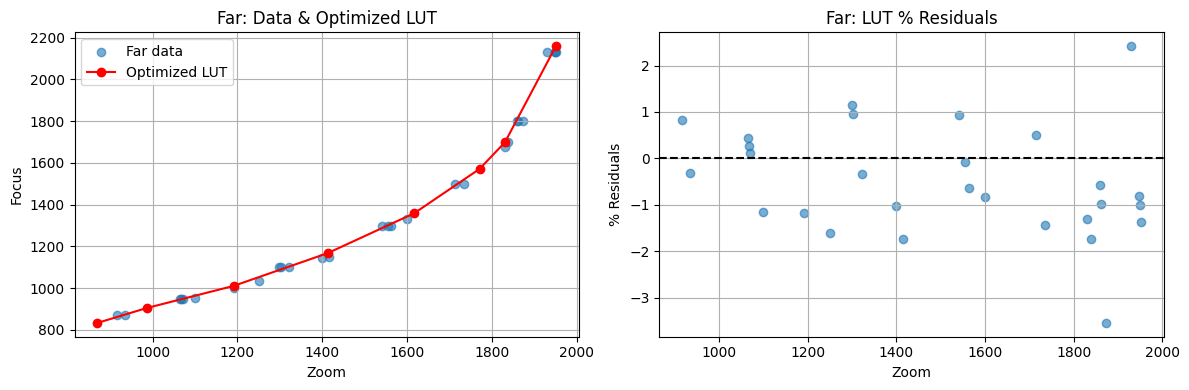

In [3]:
df = load_data()

best_joint = optimize_joint_lut_length(df,
                                       lut_min=3, lut_max=20,
                                       deg_min=2, deg_max=8,
                                       pop_size=100, n_gen=150,
                                       monotonic_penalty=True,
                                       mono_lambda=1e-2)

print("Best LUT length:", best_joint["lut_length"])
print("Close degree:", best_joint["deg_close"])
print("Far degree:", best_joint["deg_far"])
print("Shared zoom points:", best_joint["zoom_points"])
print("Metrics:", best_joint["metrics"])

plot_lut_with_residuals(df, "Close", best_joint["lut_close"], best_joint["resid_close"])
plot_lut_with_residuals(df, "Far", best_joint["lut_far"], best_joint["resid_far"])

=== CLOSE LUT ===
Old LUT metrics: {'mae_%': 2.9732352187059528, 'p95_%': 10.488104254968457, 'max_%': 13.988787091480928}
Optimized LUT metrics: {'mae_%': np.float64(0.4472636033174445), 'p95_%': np.float64(1.7415597235932854), 'max_%': np.float64(4.118935837245697)}

=== FAR LUT ===
Old LUT metrics: {'mae_%': 1.3223386253367375, 'p95_%': 4.130712530712533, 'max_%': 4.5500505561172835}
Optimized LUT metrics: {'mae_%': np.float64(0.5629759192915945), 'p95_%': np.float64(1.7357203751065609), 'max_%': np.float64(3.5462962962962923)}


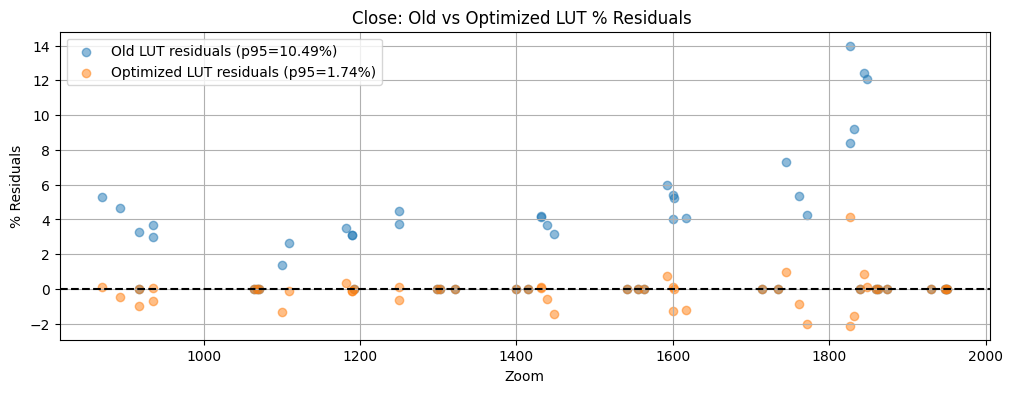

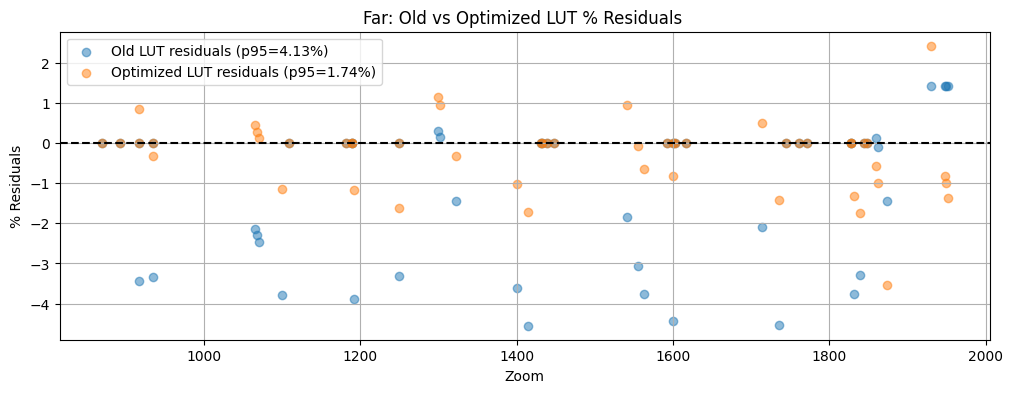

In [4]:
def evaluate_old_lut(df, col, lut_df):
    """
    Evaluate old LUT (given as DataFrame with 'Zoom' and 'Focus')
    on dataset df[col], returning residuals aligned with df.index.
    """
    x_all = df.index.values.astype(float)
    y_all = df[col].values.astype(float)

    zoom_unique, idx = np.unique(lut_df['Zoom'].values, return_index=True)
    fit_vals_unique = lut_df['Focus'].values[idx]

    pred = np.interp(x_all, zoom_unique, fit_vals_unique)

    with np.errstate(divide='ignore', invalid='ignore'):
        resid = 100.0 * (y_all - pred) / y_all
    resid = np.where(np.isfinite(resid), resid, 0.0)

    mae = float(np.mean(np.abs(resid)))
    p95 = float(np.percentile(np.abs(resid), 95))
    mxe = float(np.max(np.abs(resid)))

    return resid, {"mae_%": mae, "p95_%": p95, "max_%": mxe}

def compute_aligned_residuals(df, col, lut):
    """
    Ensure residuals are aligned with df.index for plotting.
    """
    x_all = df.index.values.astype(float)
    y_all = df[col].values.astype(float)

    zoom_unique, idx = np.unique(lut['Zoom'].values, return_index=True)
    fit_vals_unique = lut['Fit'].values[idx]

    pred = np.interp(x_all, zoom_unique, fit_vals_unique)

    with np.errstate(divide='ignore', invalid='ignore'):
        resid = 100.0 * (y_all - pred) / y_all
    resid = np.where(np.isfinite(resid), resid, 0.0)
    return resid

def plot_lut_residuals_with_p95(df, col, res_old, res_opt, title_suffix=""):
    """
    Plot old vs optimized LUT residuals for a given column, with p95 annotation.
    """
    # Compute p95
    p95_old = np.percentile(np.abs(res_old), 95)
    p95_opt = np.percentile(np.abs(res_opt), 95)

    plt.figure(figsize=(12, 4))
    plt.scatter(df.index, res_old, alpha=0.5, label=f"Old LUT residuals (p95={p95_old:.2f}%)")
    plt.scatter(df.index, res_opt, alpha=0.5, label=f"Optimized LUT residuals (p95={p95_opt:.2f}%)")
    plt.axhline(0, color='k', linestyle='--')
    plt.title(f"{col}: Old vs Optimized LUT % Residuals {title_suffix}")
    plt.xlabel("Zoom")
    plt.ylabel("% Residuals")
    plt.legend()
    plt.grid(True)
    plt.show()

# Old LUT points
closest_points = [
    {"Focus": 900, "Zoom": 882},
    {"Focus": 1100, "Zoom": 1253},
    {"Focus": 1300, "Zoom": 1498},
    {"Focus": 1500, "Zoom": 1669},
    {"Focus": 1700, "Zoom": 1759},
    {"Focus": 1900, "Zoom": 1862},
    {"Focus": 2100, "Zoom": 1883},
]

furthest_points = [
    {"Focus": 900, "Zoom": 935},
    {"Focus": 1100, "Zoom": 1305},
    {"Focus": 1300, "Zoom": 1520},
    {"Focus": 1500, "Zoom": 1696},
    {"Focus": 1700, "Zoom": 1811},
    {"Focus": 1900, "Zoom": 1911},
    {"Focus": 2100, "Zoom": 1930},
]

lut_closest_old = pd.DataFrame(closest_points)
lut_furthest_old = pd.DataFrame(furthest_points)

# Compute residuals for old LUTs
res_old_close, metrics_old_close = evaluate_old_lut(df, "Close", lut_closest_old)
res_old_far, metrics_old_far = evaluate_old_lut(df, "Far", lut_furthest_old)

# Compute residuals for optimized LUTs (joint optimized)
res_opt_close = compute_aligned_residuals(df, "Close", best_joint["lut_close"])
res_opt_far   = compute_aligned_residuals(df, "Far", best_joint["lut_far"])

# Compute metrics for optimized LUTs
mae_close_opt = np.mean(np.abs(res_opt_close))
p95_close_opt = np.percentile(np.abs(res_opt_close), 95)
max_close_opt = np.max(np.abs(res_opt_close))

mae_far_opt = np.mean(np.abs(res_opt_far))
p95_far_opt = np.percentile(np.abs(res_opt_far), 95)
max_far_opt = np.max(np.abs(res_opt_far))

metrics_opt_close = {"mae_%": mae_close_opt, "p95_%": p95_close_opt, "max_%": max_close_opt}
metrics_opt_far   = {"mae_%": mae_far_opt,   "p95_%": p95_far_opt,   "max_%": max_far_opt}

# Print comparison
print("=== CLOSE LUT ===")
print("Old LUT metrics:", metrics_old_close)
print("Optimized LUT metrics:", metrics_opt_close)

print("\n=== FAR LUT ===")
print("Old LUT metrics:", metrics_old_far)
print("Optimized LUT metrics:", metrics_opt_far)

# Plot
plot_lut_residuals_with_p95(df, "Close", res_old_close, res_opt_close)
plot_lut_residuals_with_p95(df, "Far", res_old_far, res_opt_far)


In [5]:
display("Close:", best_joint["lut_close"])
display("Far:", best_joint["lut_far"])

'Close:'

,Zoom,Fit
0,870,949
1,986,975
2,1191,1102
3,1413,1277
4,1617,1518
5,1771,1836
6,1831,2057
7,1951,2556


'Far:'

,Zoom,Fit
0,870,834
1,986,905
2,1191,1011
3,1413,1168
4,1617,1359
5,1771,1571
6,1831,1699
7,1951,2159


In [6]:
print('pub const CLOSEST_POINTS: &[api::FocusZoomPoint] = &[')
for (zoom, focus) in best_joint["lut_close"][['Zoom', 'Fit']].values:
    print("    api::FocusZoomPoint {" + f"zoom: {zoom}, focus: {focus}," + "},")
print('];\n')

print('pub const FURTHEST_POINTS: &[api::FocusZoomPoint] = &[')
for (zoom, focus) in best_joint["lut_far"][['Zoom', 'Fit']].values:
    print("    api::FocusZoomPoint {" + f"zoom: {zoom}, focus: {focus}," + "},")
print('];\n')

pub const CLOSEST_POINTS: &[api::FocusZoomPoint] = &[
    api::FocusZoomPoint {zoom: 870, focus: 949,},
    api::FocusZoomPoint {zoom: 986, focus: 975,},
    api::FocusZoomPoint {zoom: 1191, focus: 1102,},
    api::FocusZoomPoint {zoom: 1413, focus: 1277,},
    api::FocusZoomPoint {zoom: 1617, focus: 1518,},
    api::FocusZoomPoint {zoom: 1771, focus: 1836,},
    api::FocusZoomPoint {zoom: 1831, focus: 2057,},
    api::FocusZoomPoint {zoom: 1951, focus: 2556,},
];

pub const FURTHEST_POINTS: &[api::FocusZoomPoint] = &[
    api::FocusZoomPoint {zoom: 870, focus: 834,},
    api::FocusZoomPoint {zoom: 986, focus: 905,},
    api::FocusZoomPoint {zoom: 1191, focus: 1011,},
    api::FocusZoomPoint {zoom: 1413, focus: 1168,},
    api::FocusZoomPoint {zoom: 1617, focus: 1359,},
    api::FocusZoomPoint {zoom: 1771, focus: 1571,},
    api::FocusZoomPoint {zoom: 1831, focus: 1699,},
    api::FocusZoomPoint {zoom: 1951, focus: 2159,},
];

